### Installing libraries **librosa numpy scipy matplotlib**

In [1]:
!pip install librosa numpy scipy matplotlib

### Data Preprocessing

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import butter, lfilter

# Defining function for loading audio file
def load_audio_file(file_path, sr=4000):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

# Defining high-pass filter function
def high_pass_filter(signal, sr, cutoff=80, order=10):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

def calculate_spectral_band_energy(signal, sr):
    n_fft = 256  # consistent with other feature extractions
    hop_length = 64  # consistent with other feature extractions
    S = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window='hann')
    S_magnitude = np.abs(S)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    bands = [(0, 250), (250, 500), (500, 1000), (0, 2000)]
    band_energy = np.zeros((len(bands), S.shape[1]))  # Ensure same number of columns as STFT

    for i, (f_min, f_max) in enumerate(bands):
        band_energy[i, :] = np.mean(S_magnitude[(freqs >= f_min) & (freqs <= f_max), :]**2, axis=0)

    return band_energy


# Defining function for STFT and feature extraction
def extract_features(signal, sr):
    n_fft = 256
    hop_length = 64
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window='hann')
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length)
    delta_mfccs = librosa.feature.delta(mfccs, width=9)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=9)
    spectral_band_energy = calculate_spectral_band_energy(signal, sr)

    features = np.vstack((spectrogram, mfccs, delta_mfccs, delta2_mfccs, spectral_band_energy))
    features_normalized = (features - np.min(features, axis=1, keepdims=True)) / (np.max(features, axis=1, keepdims=True) - np.min(features, axis=1, keepdims=True))
    return features_normalized, spectrogram, mfccs, delta_mfccs, delta2_mfccs, spectral_band_energy

audio_path = "/kaggle/input/dataset/HF_Lung_V1-20240819T223709Z-005/HF_Lung_V1/train/steth_20180814_09_38_28.wav"  # Adjust this path as necessary
audio, sr = load_audio_file(audio_path)
filtered_audio = high_pass_filter(audio, sr)

features_normalized, spectrogram, mfccs, delta_mfccs, delta2_mfccs, spectral_band_energy = extract_features(filtered_audio, sr)


print("Spectrogram shape:", spectrogram.shape)
print("MFCCs shape:", mfccs.shape)
print("Delta MFCCs shape:", delta_mfccs.shape)
print("Delta-Delta MFCCs shape:", delta2_mfccs.shape)
print("Spectral band energy shape:", spectral_band_energy.shape)


Spectrogram shape: (129, 938)
MFCCs shape: (20, 938)
Delta MFCCs shape: (20, 938)
Delta-Delta MFCCs shape: (20, 938)
Spectral band energy shape: (4, 938)


### Visualization

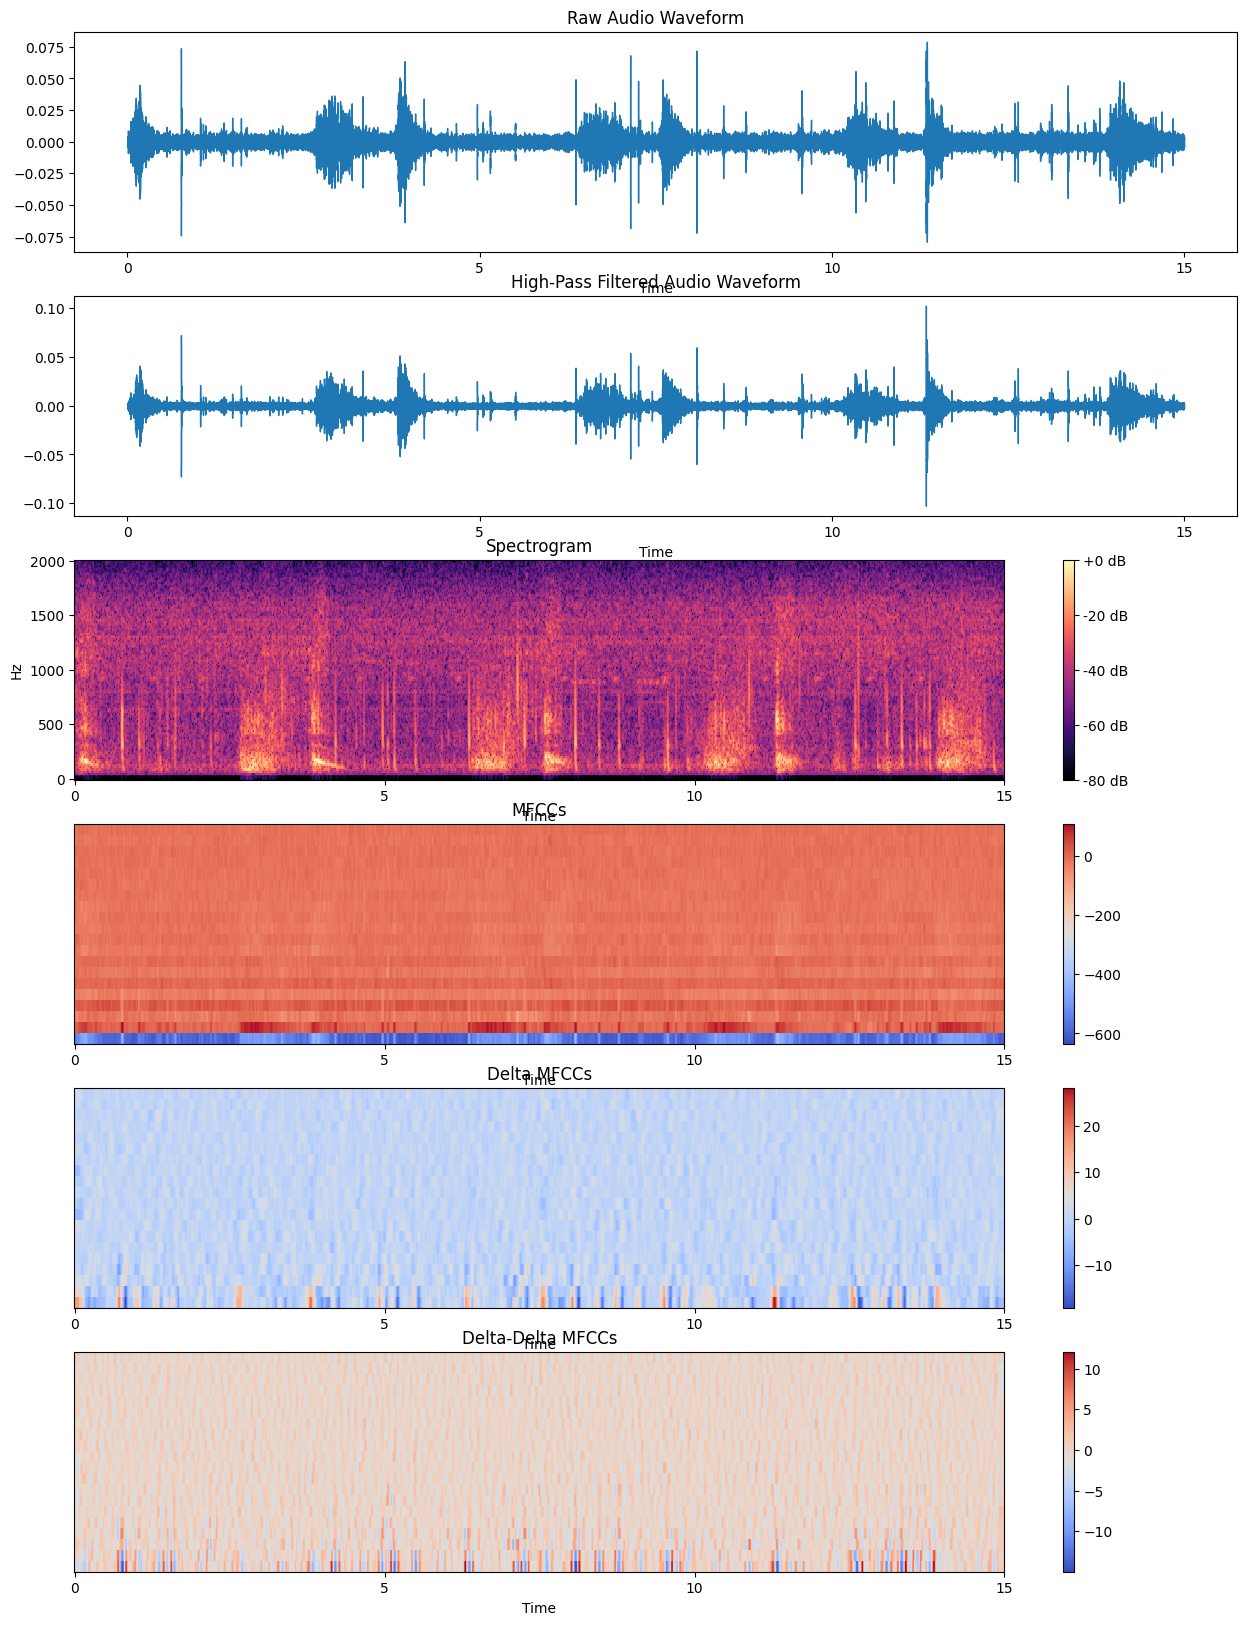

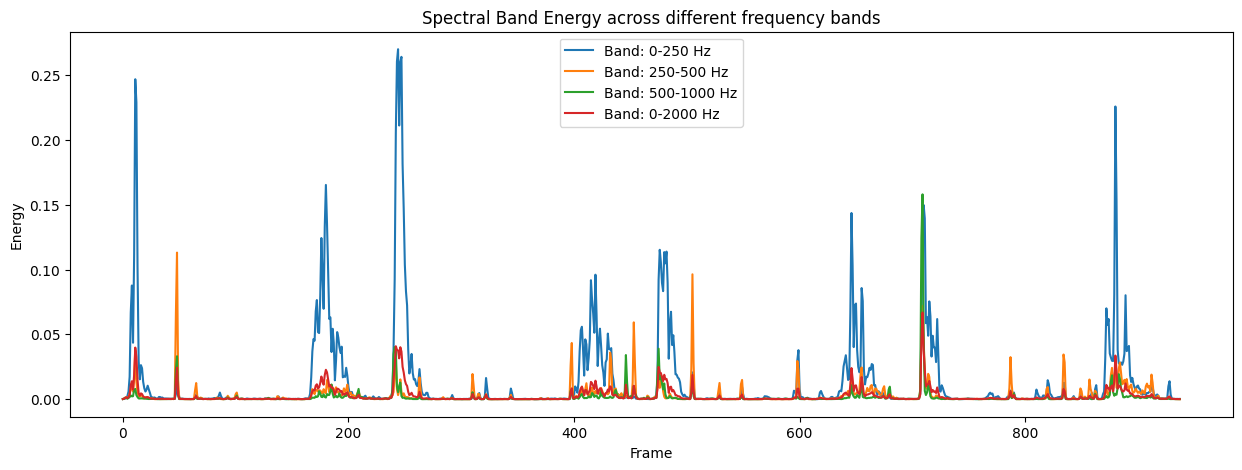

In [27]:
import matplotlib.pyplot as plt
import librosa.display

def plot_features(audio, filtered_audio, sr, spectrogram, mfccs, delta_mfccs, delta2_mfccs, spectral_band_energy):
    plt.figure(figsize=(15, 20))

    # Plotting raw audio waveform
    plt.subplot(6, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Raw Audio Waveform')

    # Plotting high-pass filtered audio waveform
    plt.subplot(6, 1, 2)
    librosa.display.waveshow(filtered_audio, sr=sr)
    plt.title('High-Pass Filtered Audio Waveform')

    # Plotting Spectrogram
    plt.subplot(6, 1, 3)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=64, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Plotting MFCCs
    plt.subplot(6, 1, 4)
    librosa.display.specshow(mfccs, sr=sr, hop_length=64, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')

    # Plotting Delta MFCCs
    plt.subplot(6, 1, 5)
    librosa.display.specshow(delta_mfccs, sr=sr, hop_length=64, x_axis='time')
    plt.colorbar()
    plt.title('Delta MFCCs')

    # Plotting Delta-Delta MFCCs
    plt.subplot(6, 1, 6)
    librosa.display.specshow(delta2_mfccs, sr=sr, hop_length=64, x_axis='time')
    plt.colorbar()
    plt.title('Delta-Delta MFCCs')

    # Creating a separate figure for spectral band energy to ensure clarity
    plt.figure(figsize=(15, 5))
    band_labels = ['0-250 Hz', '250-500 Hz', '500-1000 Hz', '0-2000 Hz']
    for i, band in enumerate(band_labels):
        plt.plot(spectral_band_energy[i, :], label=f'Band: {band}')
    plt.legend()
    plt.title('Spectral Band Energy across different frequency bands')
    plt.xlabel('Frame')
    plt.ylabel('Energy')

    plt.show()

plot_features(audio, filtered_audio, sr, spectrogram, mfccs, delta_mfccs, delta2_mfccs, spectral_band_energy)

In [ ]:
import numpy as np

spectrogram = np.zeros((129, 938))
mfccs = np.zeros((20, 938))
delta_mfccs = np.zeros((20, 938))
delta2_mfccs = np.zeros((20, 938))
spectral_band_energy = np.zeros((4, 938))

# The features are concatenated along the first axis (vertical stack)
features = np.vstack((spectrogram, mfccs, delta_mfccs, delta2_mfccs, spectral_band_energy))

features.shape, features

### Saving all the preprocessed files

In [32]:
import os
import shutil
from tqdm import tqdm

# Base path where all the directories are located
base_path = '/kaggle/input/dataset'  

# Destination directories to save the collected files
npy_destination = '/kaggle/working/collected_preprocessed_train'
label_destination = '/kaggle/working/collected_labels'

# Creating destination directories if they don't exist
os.makedirs(npy_destination, exist_ok=True)
os.makedirs(label_destination, exist_ok=True)

npy_files_count = 0
label_files_count = 0

# Loop through each directory (001 to 006)
for i in range(1, 7):
    folder_name = f'HF_Lung_V1-20240819T223709Z-00{i}'
    preprocessed_train_path = os.path.join(base_path, folder_name, 'HF_Lung_V1/preprocessed_train')
    train_path = os.path.join(base_path, folder_name, 'HF_Lung_V1/train')
    
    # Collecting all .npy files from preprocessed_train
    if os.path.exists(preprocessed_train_path):
        for npy_file in tqdm(os.listdir(preprocessed_train_path), desc=f"Copying .npy files from {folder_name}"):
            if npy_file.endswith('.npy'):
                npy_source = os.path.join(preprocessed_train_path, npy_file)
                shutil.copy(npy_source, npy_destination)
                npy_files_count += 1
    
    # Collecting all label files from train
    if os.path.exists(train_path):
        for label_file in tqdm(os.listdir(train_path), desc=f"Copying label files from {folder_name}"):
            if label_file.endswith('_label.txt'):
                label_source = os.path.join(train_path, label_file)
                shutil.copy(label_source, label_destination)
                label_files_count += 1


npy_destination_files = len(os.listdir(npy_destination))
label_destination_files = len(os.listdir(label_destination))

print(f"Expected .npy files: {npy_files_count}, Copied .npy files: {npy_destination_files}")
print(f"Expected label files: {label_files_count}, Copied label files: {label_destination_files}")

if npy_files_count == npy_destination_files:
    print("All .npy files have been successfully copied.")
else:
    print("Warning: Some .npy files might be missing.")

if label_files_count == label_destination_files:
    print("All label files have been successfully copied.")
else:
    print("Warning: Some label files might be missing.")


Copying .npy files from HF_Lung_V1-20240819T223709Z-001: 100%|██████████| 899/899 [00:21<00:00, 41.71it/s]
Copying label files from HF_Lung_V1-20240819T223709Z-001: 100%|██████████| 3323/3323 [00:12<00:00, 257.00it/s]
Copying .npy files from HF_Lung_V1-20240819T223709Z-002: 100%|██████████| 1594/1594 [00:38<00:00, 41.81it/s]
Copying label files from HF_Lung_V1-20240819T223709Z-002: 100%|██████████| 3584/3584 [00:18<00:00, 192.00it/s]
Copying .npy files from HF_Lung_V1-20240819T223709Z-003: 100%|██████████| 1671/1671 [00:39<00:00, 42.31it/s]
Copying label files from HF_Lung_V1-20240819T223709Z-003: 100%|██████████| 2110/2110 [00:11<00:00, 187.52it/s]
Copying .npy files from HF_Lung_V1-20240819T223709Z-004: 100%|██████████| 1619/1619 [00:36<00:00, 44.38it/s]
Copying label files from HF_Lung_V1-20240819T223709Z-004: 100%|██████████| 131/131 [00:00<00:00, 272.01it/s]
Copying .npy files from HF_Lung_V1-20240819T223709Z-005: 100%|██████████| 1564/1564 [00:34<00:00, 45.46it/s]
Copying label f

Expected .npy files: 7809, Copied .npy files: 7809
Expected label files: 7809, Copied label files: 7809
All .npy files have been successfully copied.
All label files have been successfully copied.


In [33]:
import os

npy_destination = '/kaggle/working/collected_preprocessed_train'
label_destination = '/kaggle/working/collected_labels'

npy_files = sorted([f for f in os.listdir(npy_destination) if f.endswith('.npy')])
label_files = sorted([f for f in os.listdir(label_destination) if f.endswith('_label.txt')])

npy_ids = set([os.path.splitext(f)[0].replace('_processed', '') for f in npy_files])
label_ids = set([os.path.splitext(f)[0].replace('_label', '') for f in label_files])

missing_labels = npy_ids - label_ids
missing_npy = label_ids - npy_ids

if not missing_labels and not missing_npy:
    print("All .npy files have corresponding label files.")
else:
    if missing_labels:
        print(f"Missing labels for the following .npy files: {missing_labels}")
    if missing_npy:
        print(f"Missing .npy files for the following labels: {missing_npy}")

All .npy files have corresponding label files.


### LSTM & GRU

In [34]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as nn_utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score

# Function to convert time string (hh:mm:ss.ms) to an index
def time_to_index(time_str, total_length, duration):
    h, m, s = map(float, time_str.split(':'))
    time_in_seconds = h * 3600 + m * 60 + s
    index = int((time_in_seconds / duration) * total_length)
    return index

# Function to parse labels and convert them into binary vectors
def parse_label_file(label_file_path, sequence_length, duration):
    label_vector = np.zeros(sequence_length)
    with open(label_file_path, 'r') as file:
        label_content = file.readlines()
    for line in label_content:
        match = re.match(r'(\w) (\d{2}:\d{2}:\d{2}\.\d{3}) (\d{2}:\d{2}:\d{2}\.\d{3})', line)
        if match:
            event, start_time, end_time = match.groups()
            start_index = time_to_index(start_time, sequence_length, duration)
            end_index = time_to_index(end_time, sequence_length, duration)
            # Marking the segment for the event as 1 (presence of event)
            label_vector[start_index:end_index] = 1
    return label_vector

# Custom dataset class for lung sound data
class LungSoundDataset(Dataset):
    def __init__(self, npy_files, label_files, sequence_length=938, duration=15):
        self.features = np.array([np.load(f) for f in npy_files])  # Converting list of arrays to a single array
        self.labels = np.array([parse_label_file(f, sequence_length, duration) for f in label_files])

    
        self.features = torch.FloatTensor(self.features[:, :sequence_length, :]).transpose(1, 2) 
        self.labels = torch.FloatTensor(self.labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class RecurrentModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, rnn_type='LSTM'):
        super(RecurrentModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'LSTM' or 'GRU'")
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        if isinstance(self.rnn, nn.LSTM):
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)
        
        out = self.fc1(out)  
        out = self.fc2(out)
        out = torch.sigmoid(out)  
        return out.squeeze(-1)  


def check_and_fix_nan(tensor, name, default_value=0.0):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}, replacing with {default_value}")
        tensor = torch.where(torch.isnan(tensor), torch.tensor(default_value).to(tensor.device), tensor)
    return tensor

def check_and_fix_bounds(tensor, name, min_val=0.0, max_val=1.0):
    if (tensor < min_val).any() or (tensor > max_val).any():
        print(f"Out-of-bounds detected in {name}, clamping to [{min_val}, {max_val}]")
        tensor = torch.clamp(tensor, min=min_val, max=max_val)
        tensor = torch.where(tensor < min_val, torch.tensor(min_val).to(tensor.device), tensor)
        tensor = torch.where(tensor > max_val, torch.tensor(max_val).to(tensor.device), tensor)
    return tensor

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, fold, model_type):
    model.to(device)
    best_val_auc = 0.0
    best_model_path = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for features, labels in tqdm(train_loader, desc=f"{model_type} Epoch {epoch+1}/{num_epochs}"):
            features, labels = features.to(device), labels.to(device)
            
            # Checking and fix NaN and bounds in features and labels
            features = check_and_fix_nan(features, "features")
            features = check_and_fix_bounds(features, "features")
            
            labels = check_and_fix_nan(labels, "labels")
            labels = check_and_fix_bounds(labels, "labels")

            optimizer.zero_grad()
            outputs = model(features)

            # Checking and fixing NaN and bounds in raw model outputs
            outputs = check_and_fix_nan(outputs, "raw model outputs")
            outputs = check_and_fix_bounds(outputs, "raw model outputs")

            # Applying sigmoid activation to ensure outputs are between 0 and 1
            outputs = torch.sigmoid(outputs)

            # Checking and fixing NaN and bounds in sigmoid outputs
            outputs = check_and_fix_nan(outputs, "sigmoid outputs")
            outputs = check_and_fix_bounds(outputs, "sigmoid outputs")

            loss = criterion(outputs, labels)

            # Checking and fixing NaN in loss
            loss = check_and_fix_nan(loss, "loss")

            loss.backward()
            
            # Applying gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Checking and fixing NaN in gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    param.grad = check_and_fix_nan(param.grad, f"gradient of {name}")

            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation step
        val_loss = 0.0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)

                
                features = check_and_fix_nan(features, "validation features")
                features = check_and_fix_bounds(features, "validation features")

                labels = check_and_fix_nan(labels, "validation labels")
                labels = check_and_fix_bounds(labels, "validation labels")
                
                outputs = model(features)

                
                outputs = check_and_fix_nan(outputs, "validation raw outputs")
                outputs = check_and_fix_bounds(outputs, "validation raw outputs")

                outputs = torch.sigmoid(outputs)
                outputs = check_and_fix_bounds(outputs, "validation clamped outputs")
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                all_labels.append(labels.cpu().numpy())
                all_outputs.append(outputs.cpu().numpy())
        
        all_labels = np.concatenate(all_labels).flatten()
        all_outputs = np.concatenate(all_outputs).flatten()
        
        val_auc = roc_auc_score(all_labels, all_outputs)
        val_f1 = f1_score(all_labels, all_outputs > 0.5)
        
        print(f"{model_type} Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}")
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_path = f"/kaggle/working/best_{model_type}_Model_fold_{fold+1}_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), best_model_path)

    return best_model_path


# Cross-validation setup and training
def run_cross_validation(npy_files, label_files, input_size, hidden_size, num_layers, num_epochs, learning_rate, device):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    best_models = {'LSTM': [], 'GRU': []}
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(npy_files)):
        print(f"Training fold {fold+1}/{kfold.n_splits}")
        
        train_npy_files = [npy_files[i] for i in train_idx]
        val_npy_files = [npy_files[i] for i in val_idx]
        train_label_files = [label_files[i] for i in train_idx]
        val_label_files = [label_files[i] for i in val_idx]
        
        train_dataset = LungSoundDataset(train_npy_files, train_label_files)
        val_dataset = LungSoundDataset(val_npy_files, val_label_files)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)
        
        # Training LSTM model
        lstm_model = RecurrentModel(input_size, hidden_size, num_layers, 'LSTM')
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
        best_lstm_model_path = train_model(lstm_model, train_loader, val_loader, criterion, optimizer, num_epochs, device, fold, 'LSTM')
        best_models['LSTM'].append(best_lstm_model_path)
        
        # Training GRU model
        gru_model = RecurrentModel(input_size, hidden_size, num_layers, 'GRU')
        optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
        best_gru_model_path = train_model(gru_model, train_loader, val_loader, criterion, optimizer, num_epochs, device, fold, 'GRU')
        best_models['GRU'].append(best_gru_model_path)
    
    print(f"Best LSTM models from each fold: {best_models['LSTM']}")
    print(f"Best GRU models from each fold: {best_models['GRU']}")
    return best_models

# Paths to the preprocessed features and label files
npy_destination = '/kaggle/working/collected_preprocessed_train'
label_destination = '/kaggle/working/collected_labels'

npy_files = sorted([os.path.join(npy_destination, f) for f in os.listdir(npy_destination) if f.endswith('.npy')])
label_files = sorted([os.path.join(label_destination, f) for f in os.listdir(label_destination) if f.endswith('_label.txt')])

# Parameters for model training
input_size = 193  # Feature dimension
hidden_size = 128  # Hidden units in RNN cells
num_layers = 2  # Number of RNN layers
num_epochs = 5  # Number of epochs to train
learning_rate = 0.0001  # Learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Runnning cross-validation and train models
best_model_paths = run_cross_validation(npy_files, label_files, input_size, hidden_size, num_layers, num_epochs, learning_rate, device)
print("Training complete. Best models saved from each fold:", best_model_paths)


Training fold 1/3


LSTM Epoch 1/5:  79%|███████▊  | 128/163 [01:47<00:27,  1.27it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 1/5: 100%|██████████| 163/163 [02:16<00:00,  1.20it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 1/5
Train Loss: 0.7224
Val Loss: 0.6942
Val AUC: 0.4068, Val F1: 0.5114


LSTM Epoch 2/5:  90%|████████▉ | 146/163 [02:07<00:13,  1.24it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 2/5: 100%|██████████| 163/163 [02:22<00:00,  1.15it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 2/5
Train Loss: 0.6938
Val Loss: 0.6936
Val AUC: 0.4082, Val F1: 0.5114


LSTM Epoch 3/5:  89%|████████▉ | 145/163 [02:04<00:15,  1.17it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 3/5: 100%|██████████| 163/163 [02:19<00:00,  1.16it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 3/5
Train Loss: 0.6935
Val Loss: 0.6934
Val AUC: 0.4094, Val F1: 0.5114


LSTM Epoch 4/5:  15%|█▌        | 25/163 [00:24<01:56,  1.18it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 4/5: 100%|██████████| 163/163 [02:21<00:00,  1.15it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 4/5
Train Loss: 0.6934
Val Loss: 0.6933
Val AUC: 0.4104, Val F1: 0.5114


LSTM Epoch 5/5:  47%|████▋     | 77/163 [01:08<01:15,  1.14it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 5/5: 100%|██████████| 163/163 [02:23<00:00,  1.13it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 5/5
Train Loss: 0.6933
Val Loss: 0.6933
Val AUC: 0.4113, Val F1: 0.5114


GRU Epoch 1/5:  79%|███████▊  | 128/163 [03:04<00:49,  1.42s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 1/5: 100%|██████████| 163/163 [03:55<00:00,  1.45s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 1/5
Train Loss: 0.7102
Val Loss: 0.6940
Val AUC: 0.3871, Val F1: 0.5114


GRU Epoch 2/5:  47%|████▋     | 76/163 [01:54<02:06,  1.45s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 2/5: 100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 2/5
Train Loss: 0.6936
Val Loss: 0.6934
Val AUC: 0.3894, Val F1: 0.5114


GRU Epoch 3/5:  63%|██████▎   | 103/163 [02:31<01:25,  1.42s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 3/5: 100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 3/5
Train Loss: 0.6934
Val Loss: 0.6933
Val AUC: 0.3897, Val F1: 0.5114


GRU Epoch 4/5:  12%|█▏        | 19/163 [00:31<03:40,  1.53s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 4/5: 100%|██████████| 163/163 [04:01<00:00,  1.48s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 4/5
Train Loss: 0.6933
Val Loss: 0.6932
Val AUC: 0.3899, Val F1: 0.5114


GRU Epoch 5/5:  14%|█▍        | 23/163 [00:34<03:23,  1.45s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 5/5: 100%|██████████| 163/163 [03:53<00:00,  1.43s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 5/5
Train Loss: 0.6932
Val Loss: 0.6932
Val AUC: 0.3899, Val F1: 0.5114
Training fold 2/3


LSTM Epoch 1/5:  55%|█████▌    | 90/163 [01:19<01:01,  1.19it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 1/5: 100%|██████████| 163/163 [02:22<00:00,  1.15it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 1/5
Train Loss: 0.7185
Val Loss: 0.6940
Val AUC: 0.4075, Val F1: 0.5160


LSTM Epoch 2/5:  68%|██████▊   | 111/163 [01:36<00:43,  1.19it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 2/5: 100%|██████████| 163/163 [02:21<00:00,  1.15it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 2/5
Train Loss: 0.6937
Val Loss: 0.6935
Val AUC: 0.4075, Val F1: 0.5160


LSTM Epoch 3/5:  89%|████████▉ | 145/163 [02:06<00:15,  1.15it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 3/5: 100%|██████████| 163/163 [02:22<00:00,  1.15it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 3/5
Train Loss: 0.6935
Val Loss: 0.6934
Val AUC: 0.4077, Val F1: 0.5160


LSTM Epoch 4/5:  13%|█▎        | 22/163 [00:31<02:01,  1.16it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 4/5: 100%|██████████| 163/163 [02:33<00:00,  1.06it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 4/5
Train Loss: 0.6934
Val Loss: 0.6933
Val AUC: 0.4076, Val F1: 0.5160


LSTM Epoch 5/5:   2%|▏         | 3/163 [00:05<03:55,  1.47s/it]

NaN detected in features, replacing with 0.0


LSTM Epoch 5/5: 100%|██████████| 163/163 [02:30<00:00,  1.08it/s]


NaN detected in validation features, replacing with 0.0
LSTM Epoch 5/5
Train Loss: 0.6933
Val Loss: 0.6933
Val AUC: 0.4074, Val F1: 0.5160


GRU Epoch 1/5:  44%|████▎     | 71/163 [01:44<02:12,  1.44s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 1/5: 100%|██████████| 163/163 [03:59<00:00,  1.47s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 1/5
Train Loss: 0.7120
Val Loss: 0.6941
Val AUC: 0.4243, Val F1: 0.5160


GRU Epoch 2/5:  22%|██▏       | 36/163 [00:54<03:08,  1.48s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 2/5: 100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 2/5
Train Loss: 0.6937
Val Loss: 0.6935
Val AUC: 0.4291, Val F1: 0.5160


GRU Epoch 3/5:  55%|█████▌    | 90/163 [02:15<01:52,  1.55s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 3/5: 100%|██████████| 163/163 [04:03<00:00,  1.49s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 3/5
Train Loss: 0.6934
Val Loss: 0.6933
Val AUC: 0.4308, Val F1: 0.5160


GRU Epoch 4/5:  68%|██████▊   | 111/163 [02:46<01:13,  1.41s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 4/5: 100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 4/5
Train Loss: 0.6933
Val Loss: 0.6932
Val AUC: 0.4315, Val F1: 0.5160


GRU Epoch 5/5:   2%|▏         | 4/163 [00:07<04:22,  1.65s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 5/5: 100%|██████████| 163/163 [04:01<00:00,  1.48s/it]


NaN detected in validation features, replacing with 0.0
GRU Epoch 5/5
Train Loss: 0.6932
Val Loss: 0.6932
Val AUC: 0.4318, Val F1: 0.5160
Training fold 3/3


LSTM Epoch 1/5:  55%|█████▍    | 89/163 [01:17<01:00,  1.22it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 1/5:  97%|█████████▋| 158/163 [02:15<00:04,  1.20it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 1/5: 100%|██████████| 163/163 [02:20<00:00,  1.16it/s]


LSTM Epoch 1/5
Train Loss: 0.7173
Val Loss: 0.6940
Val AUC: 0.4072, Val F1: 0.5130


LSTM Epoch 2/5:  12%|█▏        | 20/163 [00:19<01:55,  1.23it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 2/5:  55%|█████▍    | 89/163 [01:16<01:00,  1.21it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 2/5: 100%|██████████| 163/163 [02:18<00:00,  1.17it/s]


LSTM Epoch 2/5
Train Loss: 0.6937
Val Loss: 0.6936
Val AUC: 0.4081, Val F1: 0.5130


LSTM Epoch 3/5:  10%|▉         | 16/163 [00:15<02:02,  1.20it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 3/5:  29%|██▉       | 48/163 [00:42<01:35,  1.20it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 3/5: 100%|██████████| 163/163 [02:40<00:00,  1.02it/s]


LSTM Epoch 3/5
Train Loss: 0.6935
Val Loss: 0.6934
Val AUC: 0.4064, Val F1: 0.5130


LSTM Epoch 4/5:  36%|███▌      | 58/163 [00:55<01:35,  1.10it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 4/5:  66%|██████▋   | 108/163 [01:41<00:49,  1.10it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 4/5: 100%|██████████| 163/163 [02:32<00:00,  1.07it/s]


LSTM Epoch 4/5
Train Loss: 0.6934
Val Loss: 0.6933
Val AUC: 0.4045, Val F1: 0.5130


LSTM Epoch 5/5:  38%|███▊      | 62/163 [01:01<01:29,  1.13it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 5/5:  82%|████████▏ | 133/163 [02:04<00:25,  1.17it/s]

NaN detected in features, replacing with 0.0


LSTM Epoch 5/5: 100%|██████████| 163/163 [02:30<00:00,  1.08it/s]


LSTM Epoch 5/5
Train Loss: 0.6933
Val Loss: 0.6933
Val AUC: 0.4037, Val F1: 0.5130


GRU Epoch 1/5:  32%|███▏      | 52/163 [01:21<02:46,  1.50s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 1/5:  53%|█████▎    | 87/163 [02:15<01:54,  1.50s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 1/5: 100%|██████████| 163/163 [04:31<00:00,  1.66s/it]


GRU Epoch 1/5
Train Loss: 0.7130
Val Loss: 0.6942
Val AUC: 0.4031, Val F1: 0.5130


GRU Epoch 2/5:  21%|██▏       | 35/163 [00:55<03:11,  1.50s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 2/5:  93%|█████████▎| 151/163 [03:52<00:17,  1.45s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 2/5: 100%|██████████| 163/163 [04:10<00:00,  1.54s/it]


GRU Epoch 2/5
Train Loss: 0.6937
Val Loss: 0.6935
Val AUC: 0.4045, Val F1: 0.5130


GRU Epoch 3/5:  34%|███▍      | 56/163 [01:26<02:54,  1.63s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 3/5:  79%|███████▉  | 129/163 [03:18<00:51,  1.53s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 3/5: 100%|██████████| 163/163 [04:19<00:00,  1.59s/it]


GRU Epoch 3/5
Train Loss: 0.6934
Val Loss: 0.6933
Val AUC: 0.4049, Val F1: 0.5130


GRU Epoch 4/5:  30%|███       | 49/163 [01:16<02:56,  1.55s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 4/5:  68%|██████▊   | 111/163 [02:48<01:15,  1.45s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 4/5: 100%|██████████| 163/163 [04:04<00:00,  1.50s/it]


GRU Epoch 4/5
Train Loss: 0.6933
Val Loss: 0.6933
Val AUC: 0.4048, Val F1: 0.5130


GRU Epoch 5/5:  53%|█████▎    | 87/163 [02:08<01:50,  1.45s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 5/5:  75%|███████▍  | 122/163 [02:58<00:57,  1.41s/it]

NaN detected in features, replacing with 0.0


GRU Epoch 5/5: 100%|██████████| 163/163 [03:57<00:00,  1.46s/it]


GRU Epoch 5/5
Train Loss: 0.6932
Val Loss: 0.6932
Val AUC: 0.4047, Val F1: 0.5130
Best LSTM models from each fold: ['/kaggle/working/best_LSTM_Model_fold_1_epoch_5.pth', '/kaggle/working/best_LSTM_Model_fold_2_epoch_3.pth', '/kaggle/working/best_LSTM_Model_fold_3_epoch_2.pth']
Best GRU models from each fold: ['/kaggle/working/best_GRU_Model_fold_1_epoch_5.pth', '/kaggle/working/best_GRU_Model_fold_2_epoch_5.pth', '/kaggle/working/best_GRU_Model_fold_3_epoch_3.pth']
Training complete. Best models saved from each fold: {'LSTM': ['/kaggle/working/best_LSTM_Model_fold_1_epoch_5.pth', '/kaggle/working/best_LSTM_Model_fold_2_epoch_3.pth', '/kaggle/working/best_LSTM_Model_fold_3_epoch_2.pth'], 'GRU': ['/kaggle/working/best_GRU_Model_fold_1_epoch_5.pth', '/kaggle/working/best_GRU_Model_fold_2_epoch_5.pth', '/kaggle/working/best_GRU_Model_fold_3_epoch_3.pth']}


In [5]:
import os
import shutil

# Paths to the best models
best_model_paths = {
    'LSTM': [
        '/kaggle/working/best_LSTM_Model_fold_1_epoch_2.pth',
        '/kaggle/working/best_LSTM_Model_fold_2_epoch_2.pth',
        '/kaggle/working/best_LSTM_Model_fold_3_epoch_1.pth'
    ],
    'GRU': [
        '/kaggle/working/best_GRU_Model_fold_1_epoch_5.pth',
        '/kaggle/working/best_GRU_Model_fold_2_epoch_5.pth',
        '/kaggle/working/best_GRU_Model_fold_3_epoch_5.pth'
    ]
}

# Directory to save the best models
best_models_dir = '/kaggle/working/best_models'
os.makedirs(best_models_dir, exist_ok=True)

# Copying the best models to the directory
for model_type, paths in best_model_paths.items():
    for path in paths:
        shutil.copy(path, best_models_dir)

print(f"Best models have been saved in {best_models_dir}.")

Best models have been saved in /kaggle/working/best_models.


In [6]:
import shutil

shutil.make_archive('/kaggle/working/best_models', 'zip', best_models_dir)
print("Best models compressed into 'best_models.zip' for download.")

Best models compressed into 'best_models.zip' for download.


In [4]:
import os
import shutil
from tqdm import tqdm

# Define the base directory where the datasets are located
base_dir = '/kaggle/input/dataset'

# Define the subfolders that contain the test data
subfolders = [
    'HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test',
    'HF_Lung_V1-20240819T223709Z-002/HF_Lung_V1/test',
    'HF_Lung_V1-20240819T223709Z-003/HF_Lung_V1/test',
    'HF_Lung_V1-20240819T223709Z-004/HF_Lung_V1/test',
    'HF_Lung_V1-20240819T223709Z-005/HF_Lung_V1/test',
    'HF_Lung_V1-20240819T223709Z-006/HF_Lung_V1/test',
]

# Define the destination directories for .wav and .txt files in Kaggle's working directory
wav_destination = '/kaggle/working/collected_test_data/wav_files'
txt_destination = '/kaggle/working/collected_test_data/txt_files'

# Create the destination directories if they don't exist
os.makedirs(wav_destination, exist_ok=True)
os.makedirs(txt_destination, exist_ok=True)

# Iterate over each subfolder to collect .wav and .txt files
for folder in tqdm(subfolders, desc="Processing subfolders"):
    full_path = os.path.join(base_dir, folder)
    file_list = os.listdir(full_path)
    for file_name in tqdm(file_list, desc=f"Processing files in {folder}", leave=False):
        if file_name.endswith('.wav'):
            source = os.path.join(full_path, file_name)
            destination = os.path.join(wav_destination, file_name)
            shutil.copyfile(source, destination)
        elif file_name.endswith('.txt'):
            source = os.path.join(full_path, file_name)
            destination = os.path.join(txt_destination, file_name)
            shutil.copyfile(source, destination)

print("All .wav and .txt files have been successfully collected in Kaggle's working directory.")

Processing subfolders:   0%|          | 0/6 [00:00<?, ?it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:   0%|          | 0/1950 [00:00<?, ?it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:   4%|▍         | 83/1950 [00:00<00:02, 825.68it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:   9%|▊         | 166/1950 [00:00<00:02, 797.47it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:  13%|█▎        | 251/1950 [00:00<00:02, 817.05it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:  17%|█▋        | 336/1950 [00:00<00:01, 829.64it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:  22%|██▏       | 420/1950 [00:00<00:01, 825.24it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:  26%|██▌       | 503/1950 [00:00<00:01, 820.60it/s]
Processing files in HF_Lung_V1-20240819T223709Z-001/HF_Lung_V1/test:  30%|███       | 586/1950 [00:00<00

All .wav and .txt files have been successfully collected in Kaggle's working directory.


In [13]:
import os

# Defining the directories for the collected test data
wav_directory = '/kaggle/working/collected_test_data/wav_files'
txt_directory = '/kaggle/working/collected_test_data/txt_files'

# Specific filenames to check
unmatched_wav = "trunc_2019-08-08-11-08-00-L4_1(1).wav"
unmatched_txt = "trunc_2019-08-08-11-08-00-L4_12(1)_label.txt"

# Checking if the unmatched files exist in their respective directories
wav_file_exists = os.path.isfile(os.path.join(wav_directory, unmatched_wav))
txt_file_exists = os.path.isfile(os.path.join(txt_directory, unmatched_txt))

print(f"Checking for file: {unmatched_wav}")
if wav_file_exists:
    print(f"File {unmatched_wav} exists in the wav directory.")
else:
    print(f"File {unmatched_wav} does NOT exist in the wav directory.")

print(f"\nChecking for file: {unmatched_txt}")
if txt_file_exists:
    print(f"File {unmatched_txt} exists in the txt directory.")
else:
    print(f"File {unmatched_txt} does NOT exist in the txt directory.")

Checking for file: trunc_2019-08-08-11-08-00-L4_1(1).wav
File trunc_2019-08-08-11-08-00-L4_1(1).wav exists in the wav directory.

Checking for file: trunc_2019-08-08-11-08-00-L4_12(1)_label.txt
File trunc_2019-08-08-11-08-00-L4_12(1)_label.txt does NOT exist in the txt directory.


In [24]:
import os

txt_file_to_remove = 'trunc_2019-08-08-11-08-00-L4_12_label(1).txt'
txt_directory = '/kaggle/working/collected_test_data/txt_files'

file_path = os.path.join(txt_directory, txt_file_to_remove)


if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Removed file: {file_path}")
else:
    print(f"File not found: {file_path}")

Removed file: /kaggle/working/collected_test_data/txt_files/trunc_2019-08-08-11-08-00-L4_12_label(1).txt


In [25]:
import os
import re
from tqdm import tqdm

wav_directory = '/kaggle/working/collected_test_data/wav_files'
txt_directory = '/kaggle/working/collected_test_data/txt_files'

wav_files = [f for f in os.listdir(wav_directory) if f.endswith('.wav')]
txt_files = [f for f in os.listdir(txt_directory) if f.endswith('.txt')]

def extract_id(filename, is_txt=False):
    # Removing '_label' from the txt filenames if present
    if is_txt:
        filename = filename.replace('_label', '')
    return filename.split('.')[0]  # Return the filename without extension for comparison

# Creating dictionaries to map the original filenames to their extracted IDs
wav_file_map = {extract_id(f): f for f in wav_files}
txt_file_map = {extract_id(f, is_txt=True): f for f in txt_files}

# Finding matches based on file IDs
matched_ids = set(wav_file_map.keys()).intersection(set(txt_file_map.keys()))
unmatched_wav_ids = set(wav_file_map.keys()).difference(set(txt_file_map.keys()))
unmatched_txt_ids = set(txt_file_map.keys()).difference(set(wav_file_map.keys()))

print(f"Total .wav files: {len(wav_files)}")
print(f"Total .txt files: {len(txt_files)}")
print(f"Number of matched pairs: {len(matched_ids)}")
print(f"Number of unmatched .wav files: {len(unmatched_wav_ids)}")
print(f"Number of unmatched .txt files: {len(unmatched_txt_ids)}")

if unmatched_wav_ids:
    print("\nUnmatched .wav files:")
    for wav_id in unmatched_wav_ids:
        print(f"{wav_file_map[wav_id]} does not have a matching .txt file")
        
if unmatched_txt_ids:
    print("\nUnmatched .txt files:")
    for txt_id in unmatched_txt_ids:
        print(f"{txt_file_map[txt_id]} does not have a matching .wav file")


Total .wav files: 1960
Total .txt files: 1960
Number of matched pairs: 1960
Number of unmatched .wav files: 0
Number of unmatched .txt files: 0


In [29]:
import torch
import os
import numpy as np
from tqdm import tqdm


wav_directory = '/kaggle/working/collected_test_data/wav_files'

wav_files = [os.path.join(wav_directory, f) for f in os.listdir(wav_directory) if f.endswith('.wav')]


test_features = []
max_length = 0

# First pass to determine the maximum length
for wav_file in tqdm(wav_files, desc="Calculating maximum length"):
    audio, sr = load_audio_file(wav_file)
    filtered_audio = high_pass_filter(audio, sr)
    features_normalized, _, _, _, _, _ = extract_features(filtered_audio, sr)
    max_length = max(max_length, features_normalized.shape[1])  # Update max_length based on current feature length

# Second pass to extract features and pad them to the maximum length
for wav_file in tqdm(wav_files, desc="Processing test data"):
    audio, sr = load_audio_file(wav_file)
    filtered_audio = high_pass_filter(audio, sr)
    features_normalized, _, _, _, _, _ = extract_features(filtered_audio, sr)

    # Pad features to max_length
    if features_normalized.shape[1] < max_length:
        padding = np.zeros((features_normalized.shape[0], max_length - features_normalized.shape[1]))
        features_normalized = np.hstack((features_normalized, padding))

    test_features.append(features_normalized)

# Converting test features to tensor format
test_features_tensor = torch.FloatTensor(np.array(test_features)).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Calculating maximum length:  48%|████▊     | 934/1960 [00:57<00:59, 17.17it/s]/tmp/ipykernel_33/1141747654.py:47: RuntimeWarning: invalid value encountered in divide
  features_normalized = (features - np.min(features, axis=1, keepdims=True)) / (np.max(features, axis=1, keepdims=True) - np.min(features, axis=1, keepdims=True))
Processing test data: 100%|██████████| 1960/1960 [01:55<00:00, 16.90it/s]


In [ ]:
lstm_model_paths = [
    '/kaggle/working/best_LSTM_Model_fold_1_epoch_2.pth',
    '/kaggle/working/best_LSTM_Model_fold_2_epoch_2.pth',
    '/kaggle/working/best_LSTM_Model_fold_3_epoch_1.pth'
]

gru_model_paths = [
    '/kaggle/working/best_GRU_Model_fold_1_epoch_5.pth',
    '/kaggle/working/best_GRU_Model_fold_2_epoch_5.pth',
    '/kaggle/working/best_GRU_Model_fold_3_epoch_5.pth'
]

# RecurrentModel class is already defined
def load_model(model_path, model_class, input_size, hidden_size, num_layers, rnn_type='LSTM'):
    model = model_class(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, rnn_type=rnn_type)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    model.eval()  # Set the model to evaluation mode
    return model

input_size = 6208 
hidden_size = 128
num_layers = 2

# Loading models
lstm_model = load_model(lstm_model_paths[0], RecurrentModel, input_size, hidden_size, num_layers, rnn_type='LSTM')
gru_model = load_model(gru_model_paths[0], RecurrentModel, input_size, hidden_size, num_layers, rnn_type='GRU')